In [1]:
import numpy as np

%load_ext autoreload
%autoreload 2

In [2]:
import logging

from kyle.evaluation import EvalStats
from kyle.sampling.fake_clf import DirichletFC
from kyle.transformations import *
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)

In [3]:
n_samples = 100000

# Dirichlet fake classifiers

Add explanation about the model and integrals

## Computing properties with integrals

The asymptotic values for ECE and accuracy can be computed through (numerical or analytical)
integration.

In [4]:
n_classes = 3
alpha = [0.2, 0.3, 0.4]

dirichlet_fc = DirichletFC(n_classes, alpha=alpha)

mostly overestimating all classes (starting at 1/n_classes) with PowerLawSimplexAut
Accuracy is 0.77769
ECE is 0.09886617086487132
ece_approx=0.09831416620741784


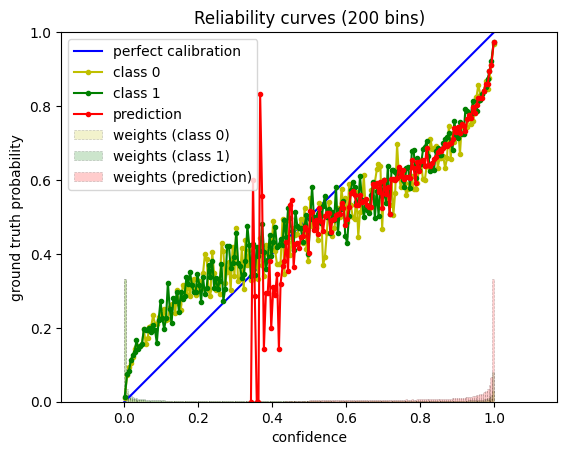

In [5]:
print(
    "mostly overestimating all classes (starting at 1/n_classes) with PowerLawSimplexAut"
)
transform = PowerLawSimplexAut(np.array([2, 2, 2]))
dirichlet_fc.set_simplex_automorphism(transform)


eval_stats = EvalStats(*dirichlet_fc.get_sample_arrays(n_samples))

print(f"Accuracy is {eval_stats.accuracy()}")
print(f"ECE is {eval_stats.expected_calibration_error(n_bins=200)}")
ece_approx = eval_stats.expected_confidence() - eval_stats.accuracy()
print(f"{ece_approx=}")
eval_stats.plot_reliability_curves(
    [0, 1, "top_class"], display_weights=True, n_bins=200
)
plt.show()


# theoretical_acc = compute_accuracy(dirichlet_fc)[0]
# theoretical_ece = compute_ECE(dirichlet_fc)[0]
# print(f"{theoretical_acc=} , {theoretical_ece=}")

mostly underestimating all classes (starting at 1/n_classes) with PowerLawSimplexAut
Note the variance and the resulting sensitivity to binning
Accuracy is 0.76436
ECE is 0.2732446876616915
ece_approx=0.2732446876616917


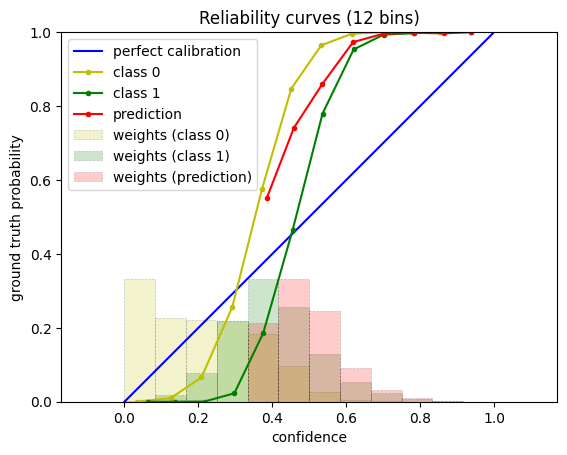

In [6]:
print(
    "mostly underestimating all classes (starting at 1/n_classes) with PowerLawSimplexAut"
)
print("Note the variance and the resulting sensitivity to binning")

transform = PowerLawSimplexAut(np.array([0.3, 0.1, 0.2]))
dirichlet_fc.set_simplex_automorphism(transform)
eval_stats = EvalStats(*dirichlet_fc.get_sample_arrays(n_samples))

print(f"Accuracy is {eval_stats.accuracy()}")
print(f"ECE is {eval_stats.expected_calibration_error()}")
ece_approx = -eval_stats.expected_confidence() + eval_stats.accuracy()
print(f"{ece_approx=}")
eval_stats.plot_reliability_curves([0, 1, "top_class"], display_weights=True)
plt.show()


# theoretical_acc = compute_accuracy(dirichlet_fc)[0]
# theoretical_ece = compute_ECE(dirichlet_fc)[0]
# print(f"{theoretical_acc=} , {theoretical_ece=}")

Underestimating predictions with MaxComponent
Accuracy is 0.77877
ECE is 0.17581826825529848


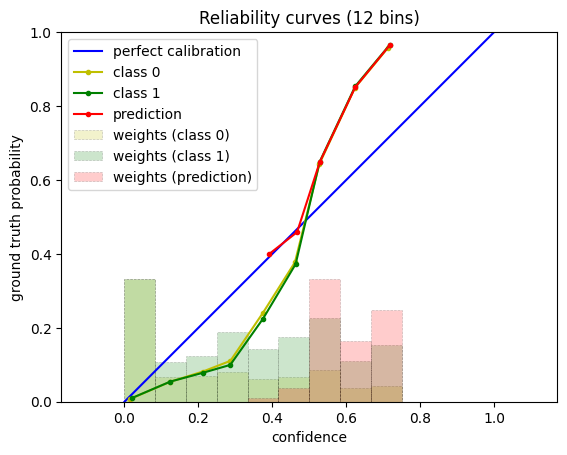

In [7]:
print("Underestimating predictions with MaxComponent")


def overestimating_max(x: np.ndarray):
    x = x.copy()
    mask = x > 1 / 2
    x[mask] = x[mask] - (1 / 4 - (1 - x[mask]) ** 2)
    return x


transform = MaxComponentSimplexAut(overestimating_max)
dirichlet_fc.set_simplex_automorphism(transform)
eval_stats = EvalStats(*dirichlet_fc.get_sample_arrays(n_samples))

print(f"Accuracy is {eval_stats.accuracy()}")
print(f"ECE is {eval_stats.expected_calibration_error()}")
eval_stats.plot_reliability_curves([0, 1, "top_class"], display_weights=True)
plt.show()

# Integrals converge pretty slowly, this takes time
# theoretical_acc = compute_accuracy(dirichlet_fc, opts={"limit": 75})[0]
# theoretical_ece = compute_ECE(dirichlet_fc, opts={"limit": 75})[0]
# print(f"{theoretical_acc=} , {theoretical_ece=}")

# Analytical results

For top-class overconfident classifiers we have

$ECE_i = \int_{A_i} \ (c_i - h_i(\vec c)) \cdot p(\vec c)$

$acc_i = \int_{A_i} \ h_i(\vec c) \cdot p(\vec c)$

In many relevant regimes, the DirichletFC can be approximately regarded as sufficiently confident.
This means we can approximate ECE and accuracy as:

$ECE_i \  \lessapprox \ \int_{\tilde A_i} \ (c_i - h_i(\vec c)) \cdot p(\vec c)$

$acc_i \ \lessapprox \ \int_{\tilde A_i} \ h_i(\vec c) \cdot p(\vec c)$

We can explicitly calculate the first part of the ECE:

$ \int_{\tilde A_i} \ c_i \cdot p(\vec c) = \frac{\alpha_i}{\alpha_0}
\left(1 - (\alpha_0-\alpha_i) \ \beta(1/2;\ \alpha_i + 1, \alpha_0-\alpha_i) \ \binom{\alpha_0}{\alpha_i} \right)$

As expected, when $\alpha_i \rightarrow \alpha_0$, this expression goes to one

The second part depends on the simplex automorphism $h$.
We can sort of compute it for the RestrictedPowerAut and for some MaxComponentSimplexAut.
However, both transforms seem to be rather on the pathological side of things...

mostly overestimating first two classes with RestrictedPowerSimplexAut
Accuracy is 0.66665
ECE is 0.1842348885201245
Theoretical approximation of ECE
0.18423488852012582


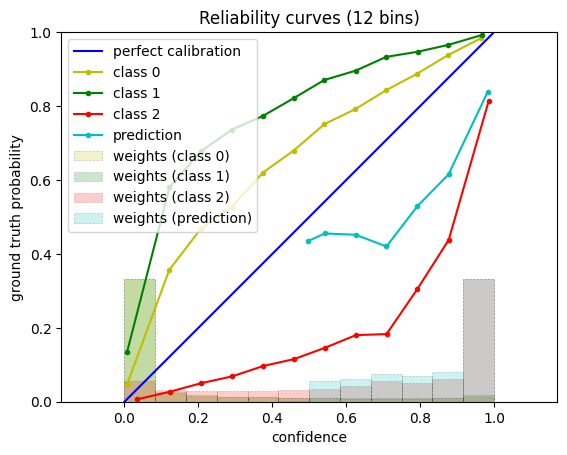

In [8]:
print("mostly overestimating first two classes with RestrictedPowerSimplexAut")

transform = RestrictedPowerSimplexAut(np.array([2, 4]))
dirichlet_fc.set_simplex_automorphism(transform)
eval_stats = EvalStats(*dirichlet_fc.get_sample_arrays(n_samples))

print(f"Accuracy is {eval_stats.accuracy()}")
print(f"ECE is {eval_stats.expected_calibration_error()}")
print("Theoretical approximation of ECE")
print(eval_stats.expected_confidence() - eval_stats.accuracy())
eval_stats.plot_reliability_curves([0, 1, 2, "top_class"], display_weights=True)
plt.show()


# theoretical_acc = compute_accuracy(dirichlet_fc)[0]
# theoretical_ece = compute_ECE(dirichlet_fc)[0]
# print(f"{theoretical_acc=} , {theoretical_ece=}")

## The Calibration Game

Below are potential 5-classes classifiers that we will use in the calibration game.
They all have roughly the same accuracy but very differing ECEs, corresponding to
different difficulty settings for the game.

In [9]:
n_classes = 5
n_samples = 500000

hardest setting: accuracy 80, ECE 18


Accuracy is 0.980054
ECE is 0.17784143376043618


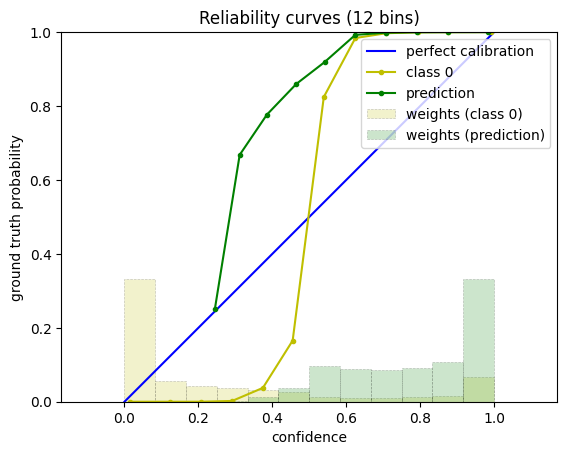

In [10]:
print("hardest setting: accuracy 80, ECE 18")

exponents = np.array([0.05, 0.4, 0.1, 0.2, 0.1]) * 2 / 3
alpha = np.ones(5) * 1 / 150

# exponents = np.ones(5) * 1/5
# alpha = np.ones(5) * 1/45

dirichlet_fc = DirichletFC(n_classes, alpha=alpha)
transform = PowerLawSimplexAut(exponents)
dirichlet_fc.set_simplex_automorphism(transform)
eval_stats = EvalStats(*dirichlet_fc.get_sample_arrays(n_samples))

print(f"Accuracy is {eval_stats.accuracy()}")
print(f"ECE is {eval_stats.expected_calibration_error(n_bins=200)}")
eval_stats.plot_reliability_curves([0, "top_class"], display_weights=True)
plt.show()

medium setting: accuracy 80, ECE 10


Accuracy is 0.9011166666666667
ECE is 0.10179867176969634


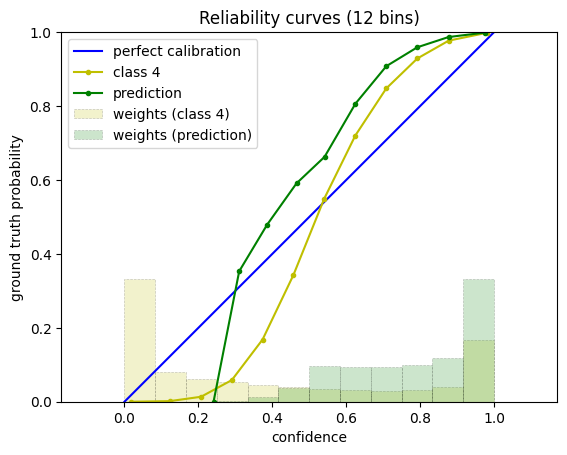

In [11]:
print("medium setting: accuracy 80, ECE 10")

exponents = np.array([0.5, 1, 1, 1, 0.5]) * 1 / 1.8
alpha = np.array([0.5, 2, 3, 4, 5]) * 1 / 65

n_samples = 300000
n_classes = 5


dirichlet_fc = DirichletFC(n_classes, alpha=alpha)
transform = PowerLawSimplexAut(exponents)
dirichlet_fc.set_simplex_automorphism(transform)
eval_stats = EvalStats(*dirichlet_fc.get_sample_arrays(n_samples))

print(f"Accuracy is {eval_stats.accuracy()}")
print(f"ECE is {eval_stats.expected_calibration_error(n_bins=200)}")
eval_stats.plot_reliability_curves([4, "top_class"], display_weights=True)
plt.show()

mostly underestimating all classes (starting at 1/n_classes)
Accuracy is 0.7947433333333334
ECE is 0.0008742277401407231


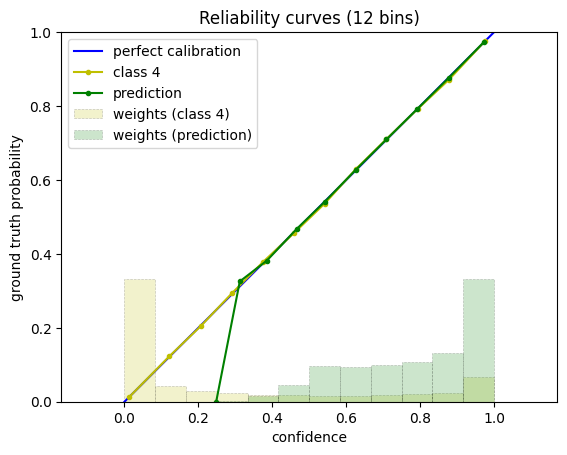

In [12]:
print("mostly underestimating all classes (starting at 1/n_classes)")


# accuracy 80, ECE 0
alpha = np.array([1, 2, 3, 2, 3]) * 1 / 19

n_samples = 300000
n_classes = 5

dirichlet_fc = DirichletFC(n_classes, alpha=alpha)
eval_stats = EvalStats(*dirichlet_fc.get_sample_arrays(n_samples))

print(f"Accuracy is {eval_stats.accuracy()}")
print(f"ECE is {eval_stats.expected_calibration_error()}")
eval_stats.plot_reliability_curves([4, "top_class"], display_weights=True)
plt.show()